
Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of Lab 3. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!


## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [ ]:
%matplotlib inline

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [ ]:
### Run this cell

from torchvision import datasets, transforms
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8012447.84it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 114936.94it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


1654784it [00:00, 2241673.47it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


8192it [00:00, 43698.56it/s]            

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        super().__init__()
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)        
        self.output3 = nn.Linear(hidden2,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)        
        if self.use_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden1)  
            self.batch_norm2 = nn.BatchNorm1d(hidden2)  
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [ ]:
# Your code here
import copy
validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 
frac_train = 0.8
size_train_data=trainloader.dataset.train_data.shape[0]
data_valid = int(size_train_data*frac_train)
#We take the 80% images for training
trainloader.dataset.data = trainloader.dataset.data[:data_valid,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:data_valid]
#We take the 20% images for validation
validloader.dataset.data = validloader.dataset.data[data_valid:,:,:]
validloader.dataset.targets = validloader.dataset.targets[data_valid:]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
class MLP_extended(MLP):
    
    # Your code here
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm,epochs=100,lr=0.001):

        # Your code here
        super().__init__(dimx,hidden1,hidden2,nlabels,use_batch_norm)  
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()               
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader, validloader):
    
        for e in range(int(self.epochs)):
            start_time = time.time()
            # Random data permutation at each epoch
            running_loss = 0.
            for images, labels in trainloader:              
                self.optim.zero_grad()  
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))

            # Perform validation 
            running_loss = 0.
            with torch.no_grad():   
              # set model to evaluation mode
              self.eval()
              for images, labels in validloader:          
                  out = self.forward(images.view(images.shape[0], -1))
                  loss = self.criterion(out, labels) 
                  running_loss += loss.item()
              self.valid_loss_during_training.append(running_loss/len(validloader))
            # set model back to train mode
            self.train()
            if(e % 5 == 0): # Every 5 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def eval_performance(self,dataloader):
        
        # Your code here
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                # Your code here
                probs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1)) 
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            return accuracy/len(dataloader)

### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

In [ ]:
net_batchnorm = MLP_extended(dimx=784,hidden1=128,hidden2=64,
                              nlabels=10,epochs=10,lr=1e-3,use_batch_norm=True)
net_no_norm = MLP_extended(dimx=784,hidden1=128,hidden2=64,
                              nlabels=10,epochs=10,lr=1e-3,use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)

MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

Epoch 0. Training loss: 0.284214, Validation loss: 0.122556, Time per epoch: 12.174341 seconds
Epoch 5. Training loss: 0.038659, Validation loss: 0.078017, Time per epoch: 11.532149 seconds
Epoch 0. Training loss: 0.439209, Validation loss: 0.251126, Time per epoch: 9.818215 seconds
Epoch 5. Training loss: 0.093775, Validation loss: 0.100881, Time per epoch: 10.874167 seconds
MLP with batch normalization
Train Accuracy 0.994875
Test Accuracy 0.976413
MLP without batch normalization
Train Accuracy 0.986417
Test Accuracy 0.973029


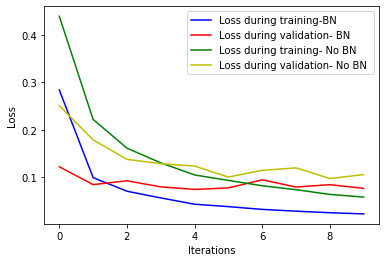

In [ ]:
# Your code here

# Model using batch normalization
net_batchnorm.trainloop(trainloader,validloader)
plt.plot(net_batchnorm.loss_during_training,'-b',label='Loss during training-BN ')
plt.plot(net_batchnorm.valid_loss_during_training,'-r',label='Loss during validation- BN ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Model not using batch normalization
net_no_norm.trainloop(trainloader,validloader)
plt.plot(net_no_norm.loss_during_training,'-g',label='Loss during training- No BN')
plt.plot(net_no_norm.valid_loss_during_training,'-y',label='Loss during validation- No BN ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

#Performance in batch normalization model
train_performance = net_batchnorm.eval_performance(trainloader)
test_performance = net_batchnorm.eval_performance(testloader)
print('MLP with batch normalization')
print("Train Accuracy %f" %(train_performance))
print("Test Accuracy %f" %(test_performance))

print('MLP without batch normalization')
#Performance in non-batch normalization model
train_performance = net_no_norm.eval_performance(trainloader)
test_performance = net_no_norm.eval_performance(testloader)
print("Train Accuracy %f" %(train_performance))
print("Test Accuracy %f" %(test_performance))

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Incorporate BN to your solution of Lab 3 (Part I). Compare the results with and without BN!!

In [ ]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        super().__init__()

        self.use_batch_norm = use_batch_norm

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
        # Linear layers
        self.fc1 = torch.nn.Linear(16 * self.final_dim**2, 120)   

        self.fc2 = torch.nn.Linear(120, 84)       

        self.fc3 = torch.nn.Linear(84, 10)        
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm2d(num_features=6)
            
            self.batch_norm2 = nn.BatchNorm2d(num_features=16)

            self.batch_norm3 = nn.BatchNorm1d(120)

            self.batch_norm4 = nn.BatchNorm1d(84)
        
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x) 
        x = self.pool(x)

        x = self.conv2(x) #YOUR CODE HERE
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = self.relu(x) 
        x = self.pool(x)

        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)

        # Pass the tensor through the Dense Layers
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = self.relu(x)

        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm4(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.logsoftmax(x)
        
        return x


In [ ]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,use_batch_norm)  
        
        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []  

        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # YOUR CODE HERE
            running_loss = 0.

            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()  

                out = self.forward(images)

                loss = self.criterion(out, labels) 

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            # Append training loss to list    
            self.loss_during_training.append(running_loss/len(trainloader))      
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():        

                # set model to evaluation mode
                self.eval()

                running_loss = 0.
                
                for images,labels in validloader:
          
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                    
                    
                    out = self.forward(images)

                    loss = self.criterion(out, labels) 

                    running_loss += loss.item()

                # Append validation loss       
                self.valid_loss_during_training.append(running_loss/len(validloader))

            # set model back to train mode
            self.train()

            if(e % 10 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            # set model to evaluation mode
            self.eval()

            for images,labels in dataloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 

                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)

                equals = (top_class == labels.view(images.shape[0], 1)) 

                accuracy += torch.mean(equals.type(torch.FloatTensor))

            # set model back to train mode
            self.train()
            
            return accuracy/len(dataloader)

Epoch 0. Training loss: 0.196160, Validation loss: 0.067663, Time per epoch: 24.535167 seconds
Epoch 10. Training loss: 0.012880, Validation loss: 0.037301, Time per epoch: 24.464852 seconds
Epoch 20. Training loss: 0.006177, Validation loss: 0.039636, Time per epoch: 24.433206 seconds
Epoch 30. Training loss: 0.004443, Validation loss: 0.042705, Time per epoch: 24.356878 seconds
Epoch 40. Training loss: 0.003253, Validation loss: 0.041498, Time per epoch: 24.298028 seconds
Epoch 50. Training loss: 0.002704, Validation loss: 0.047747, Time per epoch: 26.035949 seconds
Epoch 60. Training loss: 0.001506, Validation loss: 0.045143, Time per epoch: 24.532246 seconds
Epoch 70. Training loss: 0.001729, Validation loss: 0.047116, Time per epoch: 24.554110 seconds
Epoch 80. Training loss: 0.002743, Validation loss: 0.063445, Time per epoch: 24.294551 seconds
Epoch 90. Training loss: 0.003040, Validation loss: 0.053436, Time per epoch: 24.976438 seconds
Epoch 100. Training loss: 0.000871, Valid

Text(0, 0.5, 'Loss')

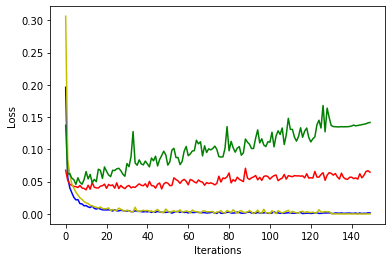

In [ ]:
my_CNN_BN = Lenet5_extended(dimx=28,nlabels=10,epochs=150,lr=1e-3,use_batch_norm=True)
my_CNN_noBN = Lenet5_extended(dimx=28,nlabels=10,epochs=150,lr=1e-3,use_batch_norm=False)
my_CNN_BN.trainloop(trainloader,validloader)
my_CNN_noBN.trainloop(trainloader, validloader)

plt.plot(my_CNN_BN.loss_during_training,'-b',label='Loss during training - BN')
plt.plot(my_CNN_BN.valid_loss_during_training,'-r',label='Loss during validation training - BN')

plt.plot(my_CNN_noBN.loss_during_training,'-y',label='Loss during training - no BN')
plt.plot(my_CNN_noBN.valid_loss_during_training,'-g',label='Loss during validation training- no BN')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
train_performance = my_CNN_BN.eval_performance(trainloader)
test_performance = my_CNN_BN.eval_performance(testloader)

print("MLP with Batch Normalisation")
print("Training Accuracy %f" %(train_performance))
print("Test Accuracy %f" %(test_performance))

train_performance = my_CNN_noBN.eval_performance(trainloader)
test_performance = my_CNN_noBN.eval_performance(testloader)

print("MLP without Batch Normalisation")
print("Training Accuracy %f" %(train_performance))
print("Test Accuracy %f" %(test_performance))

MLP with Batch Normalisation
Training Accuracy 1.000000
Test Accuracy 0.989152
MLP without Batch Normalisation
Training Accuracy 1.000000
Test Accuracy 0.992834
